In [2]:
%reload_ext autoreload
%autoreload 2

from  modules import model
import numpy as np
from scipy.special import comb
import pomegranate as pg
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
import random
import time

# File exchange 

To create the full data for the experiment:

    generate_experiment_data(n_users=100, sequence_length=120, up_to=5)
    3.41 s ± 289 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

## Data creation

In [43]:
N_USERS=100
SEQUENCE_LENGTH=120
UP_TO=5

def generate_experiment_data(n_users=N_USERS, sequence_length=SEQUENCE_LENGTH, up_to=UP_TO):
    models = [None] * n_users
    connections_sequence = np.zeros((sequence_length, n_users, model.DEVICES_NUMBER_MAX), dtype=np.bool)
    # We could make predictions 3D if overwriting previous prediction every turn
    predictions=np.zeros((sequence_length, n_users, model.DEVICES_NUMBER_MAX, up_to), dtype=np.float64)
    
    for user_id in range(n_users):
        m = model.get_random()
        models[user_id] = m

        # Generating sequence of actions for user
        sample_states, sample_obs = m.sample(length=sequence_length)
        connections_sequence[:, user_id, :m.n_obs] = sample_obs

        # Generating predictions
        for seq_id in range(sequence_length):
            for d_id in range(m.n_obs):
                # Only online devices make predictions
                if not sample_obs[seq_id, d_id]:
                    continue


                predictions[seq_id, user_id, d_id, :] = m.predict(
                    up_to=up_to, 
                    obs=d_id, 
                    s_t=sample_states[seq_id])
    
    return connections_sequence, predictions, models

connections_sequence, predictions, models = generate_experiment_data()

In [2]:
N_USERS=100
SEQUENCE_LENGTH=120
UP_TO=5

n_users = N_USERS
sequence_length = SEQUENCE_LENGTH
up_to = UP_TO

columns=['t', 'i', 'device_id', 'p']
address_book = pd.DataFrame(columns=columns)

states_columns=['t', 'user_id', 'state_id']
states_df = pd.DataFrame(columns=states_columns)

models = [None] * n_users

t0 = time.perf_counter()

for user_id in range(n_users):
    start = time.perf_counter()
    
    m = model.get_random()
    models[user_id] = m

    # Generating sequence of actions for user
    sample_states, sample_obs = m.sample(length=sequence_length)
    
    states_df = states_df.append(pd.DataFrame(
        [
            [
                t,
                user_id,
                sample_states[t]
            ] for t in range(sequence_length)
        ], columns=states_columns), ignore_index=True)
    
    for t in range(sequence_length):
         for d_id in range(m.n_obs):
            # Only online devices make predictions
            if not sample_obs[t, d_id]:
                continue
                
            address_book = address_book.append(
                pd.Series(
                    {'t': t, 
                     'i': 0,
                     'device_id': models[user_id].observations[d_id], 
                     'p': 1}
                ), ignore_index=True)
            
            address_book = address_book.append(pd.DataFrame(
                [
                    [
                        t, i+1,
                        m.observations[d_id],
                        p
                    ] for i, p in enumerate(
                        m.predict(up_to=up_to, obs=d_id, s_t=sample_states[t]))
                ], columns=columns), ignore_index=True)
            
            pred=np.empty((up_to, ))
    
    print("User #{} / {} done in {:.1f}s".format(user_id+1, n_users, time.perf_counter() - start))

states_df=pd.DataFrame(states_df, dtype=np.int)

total_time = time.perf_counter() - t0
m = total_time//60
s = total_time - m * 60
print("All done in {:.0f}m {:.1f}s".format(m, s))

User #1 / 100 done in 3.9s
User #2 / 100 done in 1.8s
User #3 / 100 done in 4.4s
User #4 / 100 done in 2.4s
User #5 / 100 done in 4.5s
User #6 / 100 done in 2.5s
User #7 / 100 done in 2.0s
User #8 / 100 done in 7.0s
User #9 / 100 done in 2.7s
User #10 / 100 done in 3.5s
User #11 / 100 done in 3.4s
User #12 / 100 done in 8.1s
User #13 / 100 done in 7.5s
User #14 / 100 done in 4.0s
User #15 / 100 done in 7.6s
User #16 / 100 done in 7.9s
User #17 / 100 done in 5.9s
User #18 / 100 done in 13.7s
User #19 / 100 done in 5.9s
User #20 / 100 done in 4.7s
User #21 / 100 done in 5.9s
User #22 / 100 done in 5.0s
User #23 / 100 done in 13.6s
User #24 / 100 done in 12.4s
User #25 / 100 done in 12.1s
User #26 / 100 done in 11.2s
User #27 / 100 done in 6.1s
User #28 / 100 done in 13.7s
User #29 / 100 done in 9.8s
User #30 / 100 done in 17.8s
User #31 / 100 done in 6.3s
User #32 / 100 done in 13.3s
User #33 / 100 done in 13.3s
User #34 / 100 done in 15.4s
User #35 / 100 done in 10.9s
User #36 / 100 don

,device_id,i,p,t,time
0,vd4p0p9sbk1njfsp_mobile,NaN,1.000000,NaN,0.0
1,vd4p0p9sbk1njfsp_mobile,1,0.973576,0,NaN
2,vd4p0p9sbk1njfsp_mobile,2,0.969701,0,NaN
3,vd4p0p9sbk1njfsp_mobile,3,0.964612,0,NaN
4,vd4p0p9sbk1njfsp_mobile,4,0.961006,0,NaN
5,vd4p0p9sbk1njfsp_mobile,5,0.958731,0,NaN
6,ydgsfhwkizcvxbzu_server,NaN,1.000000,NaN,0.0
7,ydgsfhwkizcvxbzu_server,1,0.938827,0,NaN
8,ydgsfhwkizcvxbzu_server,2,0.938827,0,NaN
9,ydgsfhwkizcvxbzu_server,3,0.938827,0,NaN


## Routes creation

First test out a route with 3 intermediaries: no care taken in RV points (sender-receiver anonymity)

In [2]:
address_book=pd.read_csv("outputs/experiment/address_book.csv", index_col=0)
states_df=pd.read_csv("outputs/experiment/states.csv",index_col=0)

In [28]:
SEQUENCE_LENGTH=120
t = random.randint(0, SEQUENCE_LENGTH)
ROUTE_SIZE = 3

print("t =", t)

connected = address_book[
    (address_book['t'] == t) & 
    (address_book['i'] == 0) & 
    (address_book['p'] == 1)]['device_id'].values
next_turn_connected = address_book[
    (address_book['t'] == t+1) & 
    (address_book['i'] == 0) &
    (address_book['p'] == 1)]['device_id'].values

print("Coennected devices at t:", len(connected))
print("Coennected devices at t+1:", len(next_turn_connected))

def pick_couple(connected):
    d1 = random.choice(connected)
    d2 = random.choice(connected)
    while d1 == d2:
        d2 = random.choice(connected)
        
    return d1, d2

d1, d2 = pick_couple(connected)
# Should check the amount of couples that are not connected on the next turn
while d1 not in next_turn_connected or d2 not in next_turn_connected:
    print("{} and {} won't be connected next turn, trying another couple.".format(d1, d2))
    d1, d2 = pick_couple(connected)

print("Selected nodes {} and {} for file exchange.".format(d1, d2))

    
next_turn_predictions = address_book[
    (address_book['t'] == t) & 
    (address_book['i'] == 1) &
    (address_book['device_id'] != d1) &
    (address_book['device_id'] != d2)]

rounds = int(comb(len(next_turn_predictions), ROUTE_SIZE))
print("Possible routes next turn:", rounds)

t = 17
Coennected devices at t: 419
Coennected devices at t+1: 400
t9ido55z8x6oxsnd_fixed and gn1r7ftbaexlrdk9_portable won't be connected next turn, trying another couple.
Selected nodes 8zwmya541467a2pl_server and ydgsfhwkizcvxbzu_server for file exchange.
Possible routes next turn: 11998480


In [29]:
PROGRESS_INDICATION=100

# route_success_rate_df = pd.DataFrame()
route_success_rate = np.zeros((rounds, 2), dtype=np.float64)

t0 = time.perf_counter()
t1 = t0
for i, relays in enumerate(combinations(next_turn_predictions['device_id'].values, ROUTE_SIZE)):
    if i != 0 and i % (rounds // PROGRESS_INDICATION) == 0:
        t2 = time.perf_counter()
        print("{:.1f}% done in {:.1f}s: i = {}, rounds = {}".format((i / rounds) * 100, t2 - t1, i, rounds))
        t1 = t2

#     p = next_turn_predictions[next_turn_predictions['device_id'].isin(relays)]['p'].prod()
#     success = np.all(np.isin(relays, next_turn_connected, assume_unique=True))
#     route_success_rate_df = route_success_rate_df.append(pd.Series({
#         'p': p,
#         'success': success
#     }), ignore_index=True)

    route_success_rate[i] = [
        # Factor of proba of being online of relays
        next_turn_predictions[next_turn_predictions['device_id'].isin(relays)]['p'].prod(), 
        # Will route be on next turn? "And" of presence of all relays 
        np.all(np.isin(relays, next_turn_connected, assume_unique=True))
    ]

# Sort by p
route_success_rate=route_success_rate[route_success_rate[:,0].argsort()]

total_time = time.perf_counter() - t0
m = total_time//60
s = total_time - m * 60
print("All done in {:.0f}m {:.1f}s".format(m, s))

1.0% done in 77.9s: i = 119984, rounds = 11998480
2.0% done in 76.7s: i = 239968, rounds = 11998480
3.0% done in 77.2s: i = 359952, rounds = 11998480
4.0% done in 76.7s: i = 479936, rounds = 11998480
5.0% done in 77.3s: i = 599920, rounds = 11998480
6.0% done in 76.7s: i = 719904, rounds = 11998480
7.0% done in 77.0s: i = 839888, rounds = 11998480
8.0% done in 78.6s: i = 959872, rounds = 11998480
9.0% done in 76.6s: i = 1079856, rounds = 11998480
10.0% done in 78.3s: i = 1199840, rounds = 11998480
11.0% done in 77.5s: i = 1319824, rounds = 11998480
12.0% done in 76.6s: i = 1439808, rounds = 11998480
13.0% done in 77.3s: i = 1559792, rounds = 11998480
14.0% done in 76.9s: i = 1679776, rounds = 11998480
15.0% done in 76.7s: i = 1799760, rounds = 11998480
16.0% done in 77.4s: i = 1919744, rounds = 11998480
17.0% done in 76.9s: i = 2039728, rounds = 11998480
18.0% done in 78.1s: i = 2159712, rounds = 11998480
19.0% done in 77.2s: i = 2279696, rounds = 11998480
20.0% done in 77.0s: i = 2399

In [31]:
np.save("outputs/experiment/route_success_rate", route_success_rate)

In [32]:
route_success_rate

array([[ 0.01978849,  0.        ],
       [ 0.02012097,  0.        ],
       [ 0.02165371,  0.        ],
       ..., 
       [ 0.99451183,  1.        ],
       [ 0.99488748,  1.        ],
       [ 0.99537706,  1.        ]])

### Compute and Plot that!

In [3]:
ROUTE_SIZE=3
route_success_rate=np.load("outputs/experiment/route_success_rate.npy")
route_success_rate

array([[ 0.01978849,  0.        ],
       [ 0.02012097,  0.        ],
       [ 0.02165371,  0.        ],
       ..., 
       [ 0.99451183,  1.        ],
       [ 0.99488748,  1.        ],
       [ 0.99537706,  1.        ]])

#### Logistic regression

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

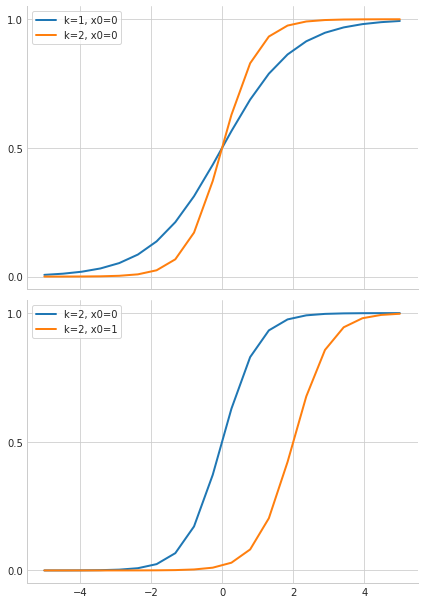

In [67]:
fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(6, 8.5), sharex=True, sharey=True)
sns.despine()
sns.set_style("whitegrid")

BOUNDS=5
COEFS = [1, 2]
INTERCEPTS = [0, 1]

x = np.linspace(-BOUNDS, BOUNDS, num=20)

def draw(ax, x, coef, intercept, label):
    y = sigmoid(coef * (x - intercept)).ravel()
    ax.plot(x, y, label=label, linewidth=2)

for i, ax in enumerate(axarr):
    if i == 0:
        draw(ax, x, 1, 0, "k=1, x0=0")
        draw(ax, x, 2, 0, "k=2, x0=0")
    else:
        draw(ax, x, 2, 0, "k=2, x0=0")
        draw(ax, x, 2, 2, "k=2, x0=2")

    ax.set_yticks([0, 0.5, 1])
    ax.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.savefig("logistic_function.pdf")
plt.show()

In [68]:
# Logistic regression of data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

# X needs to be (n_samples, 1) not (n_samples, ), hence np.newaxis
clf.fit(route_success_rate[:,0][:,np.newaxis], route_success_rate[:,1])
print("coef:", clf.coef_)
print("intercept:", clf.intercept_)
print("n_iter:", clf.n_iter_)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
y_logistic = sigmoid(route_success_rate[:,0] * clf.coef_ + clf.intercept_).ravel()

coef=clf.coef_.ravel()[0]
intercept=clf.intercept_.ravel()[0]

coef: [[ 4.05273515]]
intercept: [-2.19450805]
n_iter: [3]


In [70]:
# Heatmap computing
N_POINTS=20
data_length = route_success_rate.shape[0]
x = np.linspace(0,1, num=N_POINTS+1)
indices = np.searchsorted(route_success_rate[:,0], np.linspace(0, 1, num=N_POINTS+1))
#indices = list(zip(np.searchsorted(route_success_rate[:,0], x), x))
print(indices)

left_indices = indices[:N_POINTS]
right_indices = indices[1:]

count_arr = np.empty((N_POINTS, 2), dtype=np.float64)
#for i, ((i1, x1), (i2, x2)) in enumerate(zip(left_indices, right_indices)):
for i, (i1, i2) in enumerate(zip(left_indices, right_indices)):
    arr = route_success_rate[i1:i2,1]
    # Count successes over interval p in [x1, x2[
    count_arr[i,1] = arr.sum()
    # Count failures over interval p in [x1, x2[ and normalise
    count_arr[i,0] = (arr.shape[0] - count_arr[i, 1]) / data_length
    # Normalise successes
    count_arr[i,1] /= data_length

[       0     2876    62240   272189   624132  1158388  1910748  2844693
  3656983  4349978  5022477  5692225  6504444  7555995  8798589  9991128
 10937227 11574123 11890552 11984717 11998480]


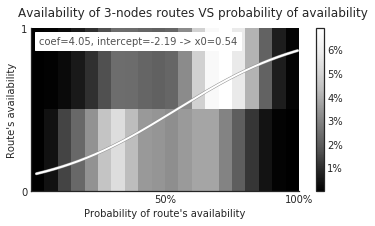

In [95]:
# Plot
fig, ax = plt.subplots(figsize=(6,3))

sns.set_style("white")
sns.despine()
im=ax.imshow(count_arr.T, cmap='Greys_r', interpolation='nearest', origin='lower', extent=[0,1,0,1], aspect='auto')
# ax.plot(x_mid, sliding_mean, linewidth=3, color='white', marker='o', markersize=None, markeredgecolor='grey')
plt.colorbar(im, ax=ax, format=plt.FuncFormatter('{:.0%}'.format))

# Visible line: draw one for the edge and another for the fill
ax.plot(route_success_rate[:,0], y_logistic, linewidth=3, color='#909090')
ax.plot(route_success_rate[:,0], y_logistic, linewidth=2, color='white')

ax.text(0.03, 0.95, 
        "coef={:.2f}, intercept={:.2f} -> x0={:.2f}".format(
            coef, intercept, -intercept/coef), 
        va="top", ha="left", backgroundcolor="white", alpha=0.8)

ax.set_xticks([0.5, 1])
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
ax.set_xlabel("Probability of route's availability")
ax.set_yticks([0, 1])
ax.set_ylabel("Route's availability")

#ax.legend(frameon=True, loc="upper left")


# plt.suptitle("Availability of {}-nodes routes VS probability of availability over {:,} routes".format(ROUTE_SIZE, data_length))
plt.suptitle("Availability of {}-nodes routes VS probability of availability".format(ROUTE_SIZE))
#plt.tight_layout()
plt.savefig("outputs/route_success_vs_proba_logistic.svg")
plt.show()

x0 is the most interesting statistics to us

Then comes coef, that states whether there is a clear demarcation between failures and successes

#### Local average and heatmap

In [20]:
N_POINTS=20
data_length = route_success_rate.shape[0]
x = np.linspace(0,1, num=N_POINTS+1)
indices = list(zip(np.searchsorted(route_success_rate[:,0], x), x))

left_indices = indices[:N_POINTS]
right_indices = indices[1:]

sliding_mean = np.empty(N_POINTS, dtype=np.float64)
count_arr = np.empty((N_POINTS, 2), dtype=np.float64)
x_mid=np.empty(N_POINTS, dtype=np.float64)
for i, ((i1, x1), (i2, x2)) in enumerate(zip(left_indices, right_indices)):
    x_mid[i] = x1+(x2-x1)/2
    arr = route_success_rate[i1:i2,1]
#     print(i, ((i1, x1), (i2, x2)))
#     print(arr)
    
    # Success mean over interval p in [x1, x2[
    sliding_mean[i] = arr.mean()
    # Count successes over interval p in [x1, x2[
    count_arr[i,1] = arr.sum()
    # Count failures over interval p in [x1, x2[ and normalise
    count_arr[i,0] = (arr.shape[0] - count_arr[i, 1]) / data_length
    # Normalise successes
    count_arr[i,1] /= data_length
    
#     print(sliding_mean[i])
#     print(count_arr[i])
#     print()
    
# print(sliding_mean)
# print(count_arr)

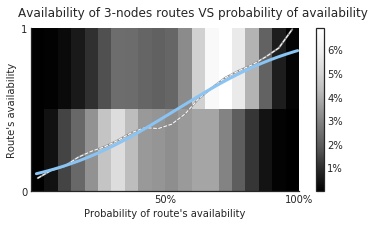

In [22]:
### print(count_arr.T)

fig, ax = plt.subplots(figsize=(6,3))

sns.set_style("white")
sns.despine()
im=ax.imshow(count_arr.T, cmap='Greys_r', interpolation='nearest', origin='lower', extent=[0,1,0,1], aspect='auto')
# ax.plot(x_mid, sliding_mean, linewidth=3, color='white', marker='o', markersize=None, markeredgecolor='grey')
plt.colorbar(im, ax=ax, format=plt.FuncFormatter('{:.0%}'.format))

# Visible line: draw one for the edge and another for the fill
ax.plot(x_mid, sliding_mean, linewidth=2, color='#909090')
ax.plot(x_mid, sliding_mean, linewidth=1, color='white', linestyle="--")

# Logistic regression
ax.plot(X, loss, linewidth=3, color="#89C4F4")

# Visible dots
# ax.plot(x_mid, sliding_mean, linewidth=0, marker='o', markersize=8, markerfacecolor='white',
#         markeredgecolor='grey', markeredgewidth=1)

# xticks=np.linspace(0, count_arr.shape[0]-1, num=3, dtype=np.uint)
# print(xticks)
# print(x_mid[xticks])
# # ax.set_xticks(xticks)
# # #ax.xaxis.set_major_formatter(plt.FuncFormatter('{:}'.format))
# # ax.set_xticklabels(x_mid[xticks])

ax.set_xticks([0.5, 1])
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
ax.set_xlabel("Probability of route's availability")
ax.set_yticks([0, 1])
ax.set_ylabel("Route's availability")


# plt.suptitle("Availability of {}-nodes routes VS probability of availability over {:,} routes".format(ROUTE_SIZE, data_length))
plt.suptitle("Availability of {}-nodes routes VS probability of availability".format(ROUTE_SIZE))
#plt.tight_layout()
plt.savefig("outputs/route_success_vs_proba.svg")
plt.show()

# Plot sample

In [4]:
states_name=["H", "O", "W"]
obs_name=["p", "w", "h", "l"]
n_states=len(states_name)
n_obs=len(obs_name)
m=model.Model()
m.set(
[[2/3, 1/3, 0  ],
 [1/3, 1/3, 1/3],
 [0  , 1/3, 2/3]],
[[0.8, 0.0, 0.7, 0.6],
 [0.6, 0.0, 0.0, 0.4],
 [0.7, 0.7, 0.0, 0.2]],
states_name, obs_name)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def plot_device_usage_timeline(
    sample_states, sample_devices, states, devices,
    figsize=(6,1.5), title="", fn=""):
    
    c_used = matplotlib.colors.hex2color("#444444")
    height = 0.5
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("whitegrid", {'font.family': 'serif'})
    
    for x, (state, d_arr) in enumerate(zip(sample_states, sample_devices)):
        for y in range(len(devices)):
            if d_arr[y]:
                ax.barh(left=x, bottom=y,
                    height=height, width=1, color=c_used)
    
    
    sns.despine()
    
#     if prediction:
#         for x, pred in enumerate(sample['predictions']):
#             for device in devices:
#                 #print("x: {}, y: {} -> p: {:.2f}".format(x+1, devices_id[device], pred[device]))
#                 ax.text(x=x+1.1, y=devices_id[device]+0.1,
#                         s="{:.2f}".format(pred[device]))

#         ax.set_xlim([0, len(sample['state_seq'])+1])
#         ax.set_xticks(range(len(states)+1))
#     else:
#         ax.set_xlim([0, len(sample['state_seq'])])
#         ax.set_xticks(range(len(states)))
    
    ax.set_xlim([0, len(sample_states)])
    ax.set_xticks(range(len(sample_states)))
    ax.set_xticklabels([states[s_id] for s_id in sample_states])
    #plt.xticks(rotation=-60, ha='left')
    
    #ax.set_ylabel("Device")
    ax.set_ylim([-0.5, len(devices)-0.5])
    ax.set_yticks(range(len(devices)))
    # "c_d" as y label: devices' connections
    ax.set_yticklabels(['$o_{'+d+'}$' for d in devices], fontsize=16)
    
    plt.tight_layout()
    if title != "":
        ax.set_title(title)
    if fn != "":
        plt.savefig(fn)
    plt.show()
    
sample_states, sample_devices = m.sample(length=16)
plot_device_usage_timeline(
    sample_states, sample_devices, m.states, m.observations,
    fn="outputs/sample.svg")

# The Model: creation, generation of behavior, prediction

In [96]:
states_name=["Home", "Outside", "Work"]
obs_name=["Phone", "Home computer", "NAS", "Workstation", "Laptop"]
n_states=len(states_name)
n_obs=len(obs_name)
m=model.Model()
m.set(
[[0.5,0.5,0],
 [0.3,0.4,0.3],
 [0,0.5,0.5]],
[[0.9, 0.4, 0.99, 0.1, 0.7],
 [0.9, 0.1, 0.99, 0.1, 0.2],
 [0.7, 0.1, 0.99, 0.7, 0.3]],
states_name, obs_name)

## Generating behavior

In [95]:
states,obs=m.sample()
for s, o in zip(states, obs):
    print(states_name[s], [obs_name[i] for i in range(len(obs_name)) if o[i]])

Home ['Phone', 'Home computer', 'NAS', 'Workstation', 'Laptop']
Outside ['Phone', 'Home computer', 'NAS']
Outside ['Phone', 'NAS', 'Laptop']
Work ['Phone', 'NAS', 'Workstation', 'Laptop']
Outside ['Phone', 'NAS']
Outside ['Phone', 'NAS']
Work ['Phone', 'NAS', 'Workstation']
Outside ['Phone', 'NAS']
Outside ['Phone', 'NAS']
Outside ['Phone', 'NAS']
Home ['NAS']
Home ['Phone', 'NAS', 'Workstation', 'Laptop']
Home ['Phone', 'NAS', 'Laptop']
Home ['Phone', 'NAS', 'Laptop']
Home ['NAS']
Home ['Phone', 'Home computer', 'NAS', 'Laptop']
Home ['NAS', 'Laptop']
Home ['Phone', 'NAS']
Home ['NAS', 'Laptop']
Outside ['Phone', 'NAS']


## Plot predictions

In [97]:
UP_TO=10
predictions=np.empty((n_states, n_obs, UP_TO), dtype=np.float64)

for obs_id, obs in enumerate(obs_name):
    predictions[:, obs_id,:]=m.predict(UP_TO, obs_id).T

['t + 1', 't + 2', 't + 3', 't + 4', 't + 5', 't + 6', 't + 7', 't + 8', 't + 9', 't + 10']





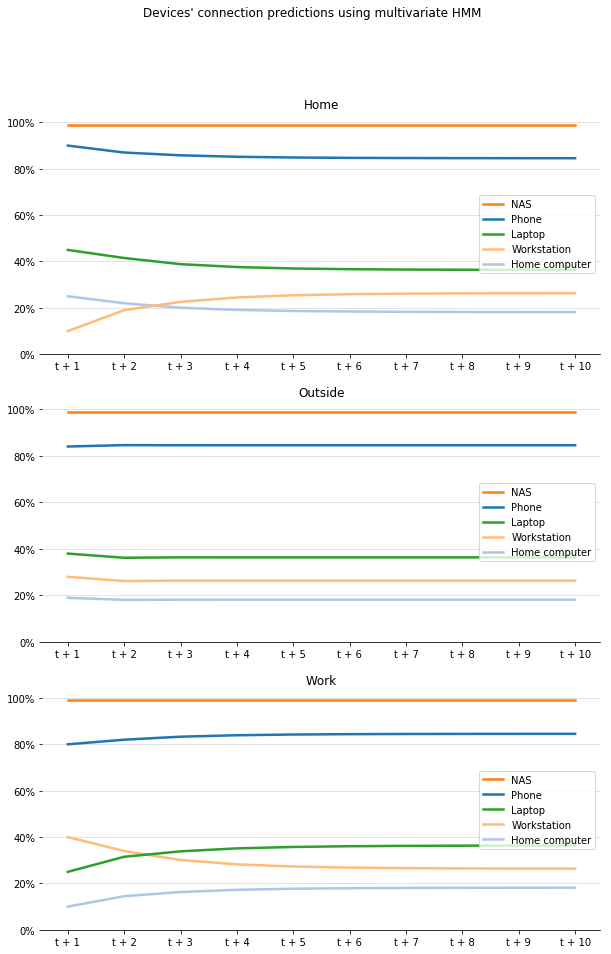

In [110]:
fig, axarr = plt.subplots(ncols=1, nrows=n_states, figsize=(10,15))
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

sns.despine(fig=fig, left=True)

time_labels = ['t + '+str(i) for i in range(1, UP_TO+1)]
print(time_labels)
time_indices = range(UP_TO)

for s_id, state in enumerate(states_name):
    ax=axarr[s_id]
    ax.set_title(state)
    
    for obs_id, obs in enumerate(obs_name):
        line = ax.plot(time_indices,
                        predictions[s_id, obs_id,:],
                        lw=2.5,
                        color=color_sequence[obs_id],
                        label=obs)
    print()
    
    ax.set_xticks(time_indices)
    ax.set_xticklabels(time_labels)
    
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    
    # Sort the legend items
    handles, labels = ax.get_legend_handles_labels()
    handles, labels, _ = zip(*sorted(zip(handles, labels, predictions[s_id, :,UP_TO-1]),
                                     key=lambda t: t[2],
                                     reverse=True))
    ax.legend(handles, labels, loc='center right')

plt.suptitle("Devices' connection predictions using multivariate HMM")
plt.savefig(filename="outputs/connection_predictions_multivariate_hmm.pdf")
plt.show()

In [92]:
import random

random.randint(3, 4)

3

## Where it fails: inferring model from data

In [49]:
default_m=model.get_default_model(m.observations)

In [52]:
default_m.fit(obs)

Observation Phone
Sequence:
['Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'non_Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'non_Phone', 'non_Phone', 'Phone', 'non_Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'Phone', 'non_Phone', 'Phone']
A:
